In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
from PIL import Image
import glob

import os
os.chdir('../')

from model.utils import int_to_datetime

results_dir = 'results/ice_results_may7_exp_0'

year_start, year_end, timestep_in, timestep_out = re.search(r'Y(\d+)_Y(\d+)_I(\d+)O(\d+)', glob.glob(results_dir+'/*.nc')[0]).groups()

months = list(range(1, 13))
ds = []
for month in months:
    try:
        ds.append(xr.open_dataset(f'{results_dir}/valpredictions_M{month}_Y{year_start}_Y{year_end}_I{timestep_in}O{timestep_out}.nc', engine='netcdf4'))
    except Exception as e: #FileNotFoundError:
        print(e)
        pass
    
ds = xr.concat(ds, dim='launch_date')
ds = ds.rio.set_crs(4326)
ds['launch_date'] = [int_to_datetime(dt) for dt in ds.launch_date.values]

In [50]:
route = np.array(Image.open('data/shipping_corridors/primary_route_mask.png').convert('L'))

route_ = xr.open_dataset(glob.glob('data/ERA5_GLORYS/*.nc')[0]).isel(time=0).siconc
route_.values = route
route = route_

In [84]:
lead_time = 15

pred_doys = []
true_doys = []

for lead_time in range(1, 91):
    route_open_list_pred = []
    route_open_list_true = []
    for ld in ds.launch_date:
        ds.sel(launch_date=ld, timestep=lead_time)

        ice_binary = (ds.sel(launch_date=ld, timestep=lead_time) > 0.15)

        route_open = (~(ice_binary * route).y_hat).all().values.item()
        route_open_list_pred.append(route_open)

        route_open = (~(ice_binary * route).y_true).all().values.item()
        route_open_list_true.append(route_open)

    pred_doy = np.where(np.cumsum(route_open_list_pred) >= 15)[0][0]
    true_doy = np.where(np.cumsum(route_open_list_true) >= 15)[0][0]
    
    pred_doys.append(pred_doy)
    true_doys.append(true_doy)
    
doys_error = np.array(true_doys) - np.array(pred_doys)

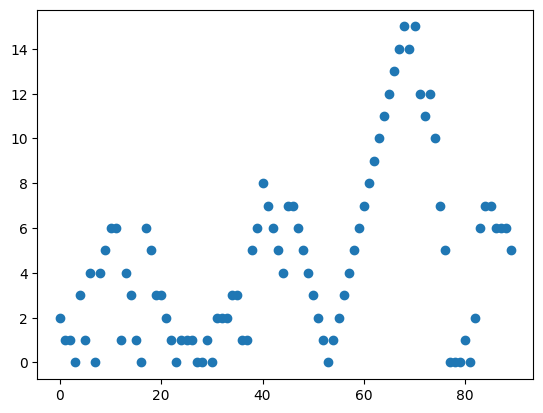

In [92]:
plt.scatter(range(90), np.abs(doys_error))

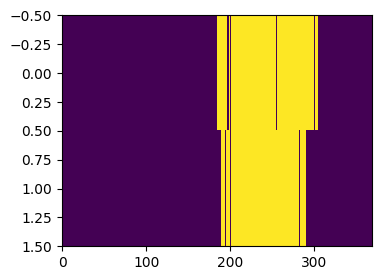

In [73]:
plt.figure(figsize=(4, 3))
plt.imshow(np.array([route_open_list_pred, route_open_list_true]), interpolation='none')
plt.gca().set_aspect('auto')
plt.show()

In [79]:
np.where(np.cumsum(route_open_list_true) >= 15)[0][0]

205

In [78]:
np.where(np.cumsum(route_open_list_pred) >= 15)[0][0]

202